In [228]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.linalg import fractional_matrix_power

import gc
gc.collect()

34927

In [198]:
data_set_p = pd.read_csv("hour3.csv") #, index_col="time")
data_set_p = data_set_p.iloc[:, 2:]

#Use forward filling, as if a price is not available, we would have a forward looking bias otherwise
data_set = data_set_p.ffill()
data_set = data_set.dropna(axis = 1)

In [200]:
subset_resample5 = data_set.astype(float)
subset_resample5 = subset_resample5.values

range_len = 200

sds = np.std(subset_resample5, axis=0)
mus = np.mean(subset_resample5, axis = 0)

sds_r = np.std(np.lib.stride_tricks.sliding_window_view(subset_resample5, range_len, axis = 0), axis = 2)    
mu_r= np.mean(np.lib.stride_tricks.sliding_window_view(subset_resample5, range_len, axis = 0), axis = 2)

"""
For all columns: take the next 200 values (range_len), including the current value and add them to an array for all values.
We then crop the first range_len values of the data + 1, so the first cell is at same hight as the std, calculated from the previous 200 values
to match size of the +1, we crop the last value of sds_r and mu_r as it includes "today" value (we dont want that, lookahead bias!
"""

demeaned_r = subset_resample5[range_len:, :]
sds_r = sds_r[:-1, :]
mu_r = mu_r[:-1, :]

#Control for shape
print(mu_r.shape)
print(sds_r.shape)
print(demeaned_r.shape)


demeaned = (demeaned_r) / (sds_r+0.0000001)

demeaned_train = demeaned[:25000, :]
demeaned_test = demeaned[25000:, :]


(34841, 34)
(34841, 34)
(34841, 34)


In [230]:
def generate_A(matrix: NDArray, lag : float) -> NDArray:
    matrix = sort_matrix(matrix)
    k = matrix.shape[0]
    
    Y = matrix[lag:, :]
    X = matrix[:-lag, :]

    print(X.shape)
    print(Y.shape)
    
    A = np.linalg.inv(X.T @ X) @ (X.T @ Y )     # predicts forward
    return A, X, Y                              #A is nxn size



def sort_matrix(matrix: NDArray) -> NDArray:
    #sorts Matrix size n x T with T >> n (n Assets, T timesteps)
    if matrix.shape[0] > matrix.shape[1]:
        return matrix
    else:
        return matrix.T



def get_weights(matrix : NDArray, lag: float) -> NDArray:

    matrix = matrix - np.mean(matrix, axis = 0)
    A, X, Y = generate_A(matrix, lag)

    d = matrix.shape[0]

    d = int(X.shape[0])
    X_T = np.transpose(X, (1, 0))
  
    print(f"X shape: {X.shape}")
    print(f"X contains NaN: {np.isnan(X).any()}")
    print(f"X contains Inf: {np.isinf(X).any()}")
    print(f"Y contains NaN: {np.isnan(Y).any()}")
    print(f"Y contains Inf: {np.isinf(Y).any()}")
    
    C = 1/(d - 1) * (X_T @ X)                                          #C is size n x n (current cov Matrix)    print(f"C contains NaN: {np.isnan(C).any()}")
    print(f"C contains Inf: {np.isinf(C).any()}")
    print(f"C condition number: {np.linalg.cond(C)}")
  
    C = 1/(d - 1) * (X_T @ X)                                          #C is size n x n (current cov Matrix)
    C_05 = np.linalg.inv(sqrtm(C)).real

    opt_ = (C_05 @ A.T) @ (C) @ (A @ C_05)
    value, vector = np.linalg.eigh(opt_)

    min_weights_z = vector[value == np.min(value)]
    min_weights_x = C_05 @ min_weights_z.T
    

    return min_weights_x





(24999, 34)
(24999, 34)
X shape: (24999, 34)
X contains NaN: False
X contains Inf: False
Y contains NaN: False
Y contains Inf: False
C contains Inf: False
C condition number: 232560950500.4297


'As we see, it generates a perfect mean reverting portfolio on the data, with no significant deviation at the end (not that w was fitted \non the first 25k values, so if it would be strongly overfit, on the last 9k entries the applied weights would have\nprobably lost their mean reverting characteristics\n'

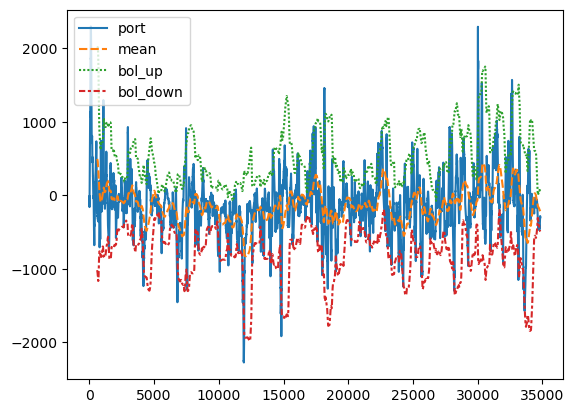

In [242]:
w = get_weights(demeaned_train, 1)
w = w / np.sum(w)

"""
The matrix of sds_r has the shape n x k and has as entries the std of the past 90 entries as values
The weights are calculated based on standarized Volatility. To achive the same outcome with raw data, we divide by the vola
as a raw stock may add 2x the vola than another, we have to halve its weight to have the same attribution
"""

w = w.reshape(-1)
lag = 600


p = demeaned @ w
df = pd.DataFrame(p, columns = ["port"])
df["mean"] = df.port.rolling(lag).mean()

df["bol_up"] = df["mean"] + 2 * df.port.rolling(lag).std()
df["bol_down"] = df["mean"] - 2 * df.port.rolling(lag).std()

sns.lineplot(df.iloc[:, :])

"""As we see, it generates a perfect mean reverting portfolio on the data, with no significant deviation at the end (not that w was fitted 
on the first 25k values, so if it would be strongly overfit, on the last 9k entries the applied weights would have
probably lost their mean reverting characteristics
"""

In [258]:
def generate_backtest(multiple_data, weights, lag, factor = 3, starting_capital = 1000000):
    """
    This takes into account the weights of the normalized data and applies them to the assets only divided by their past std
    This shall finally be reversed by rescaling positions for volatility (trivial)
    """

    #Portfolio calculated from standarized data and the weights 
    port = multiple_data @ weights
    port = port.reshape(-1, 1)
    

    #empty positions vector
    position = np.zeros(port.shape[0])
    bo_up = np.zeros(port.shape[0])
    bo_down = np.zeros(port.shape[0])
    a_mean = np.zeros(port.shape[0])

    for i in range(lag, len(port)):
        price = float(port[i, 0])
        std = np.std(port[(i-lag):(i)])       #th std and means of the post values
        mean = np.mean(port[(i-lag):(i)])
        bol_up = mean + factor * std
        bol_down = mean - factor * std

        #save for plotting later:
        bo_up[i] = bol_up
        bo_down[i] = bol_down
        a_mean[i] = mean
        
        if position[i-1] == 0:
            if price > bol_up:
                position[i] = -1 + (2* 0.036 / 100)   #this accounts for trading costs being 0.036% for taker on binance (futures)
            elif price < bol_down:                    #twice to include the selling fee, as it is mean revision this should roughly be correct
                position[i] = 1 - (2* 0.036 / 100)
            else:
                position[i] = 0
                
        #if position is long, it closes if price is above the mean and stays long if not reahed yet
        elif position[i-1] > 0:
            if price > mean:
                position[i] = 0
            if price <= mean:
                position[i] = 1
                
        #same as long case but reversed
        elif position[i-1] < 0:
            if price < mean:
                position[i] = 0 
            if price >= mean:
                position[i] = -1

    
    #cut the last position
    pos_apply = position[:-1]

    #direction_weightings = pos_apply.reshape(-1, 1) @ weights.reshape(-1, 1).T  #matrix of weights
    forward_return = (multiple_data[1:, :] / multiple_data[:-1, :] -1) 
    
    weighted_returns = forward_return @ weights.T

    port_return = weighted_returns * pos_apply
    port_return_w = port_return * (0.01 / (np.std(port_return)*24**(0.5)))
    
    #Plotting the charts 1) posrtfolio (normalized) and 2) the strategy return
    fig, axes = plt.subplots(2, 1, figsize = (8, 8))
    
    sns.lineplot(ax=axes[0], data = port[:], color = "blue")
    sns.lineplot(ax=axes[0], data = bo_up[:], color = "red")
    sns.lineplot(ax=axes[0], data = bo_down[:], color = "red")
    sns.lineplot(ax=axes[0], data = a_mean[:], color = "green")
    axes[0].set_title("Portfolio")
    
    sns.lineplot(ax = axes[1], data = np.log((np.cumprod(port_return_w + 1))))
    axes[1].set_title("Startegy_return")

    #Statistics
    sharpe = (np.mean(port_return_w) * ((24*365)**0.5)) / np.std(port_return)   #yearly sharpe ratio
    print(f"Annualized sharpe ratio: {sharpe}")
        
    return port_return_w
   

Annualized sharpe ratio: 0.10368366487215866


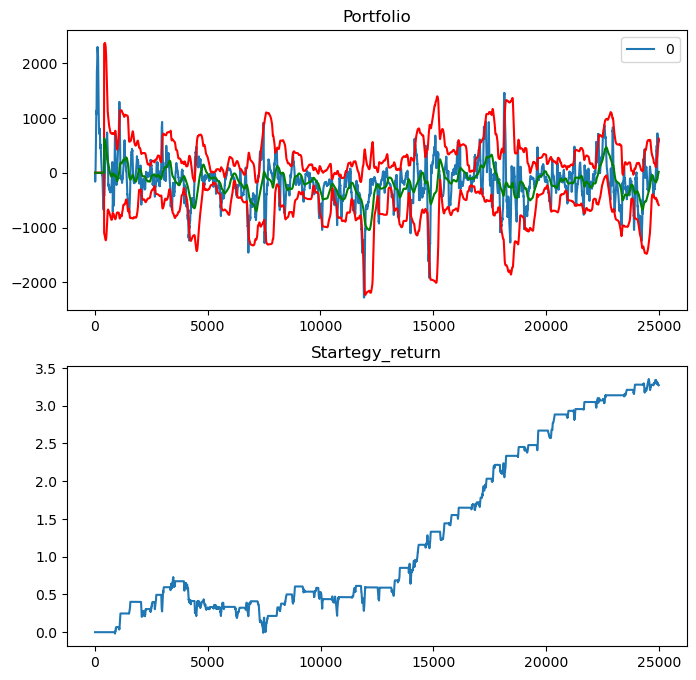

In [260]:
a = generate_backtest(demeaned_train, w, 400, factor = 2)  #with the training data

Annualized sharpe ratio: 0.08149763070553244


array([ 0.        ,  0.        ,  0.        , ..., -0.00079701,
        0.00051507, -0.0022903 ])

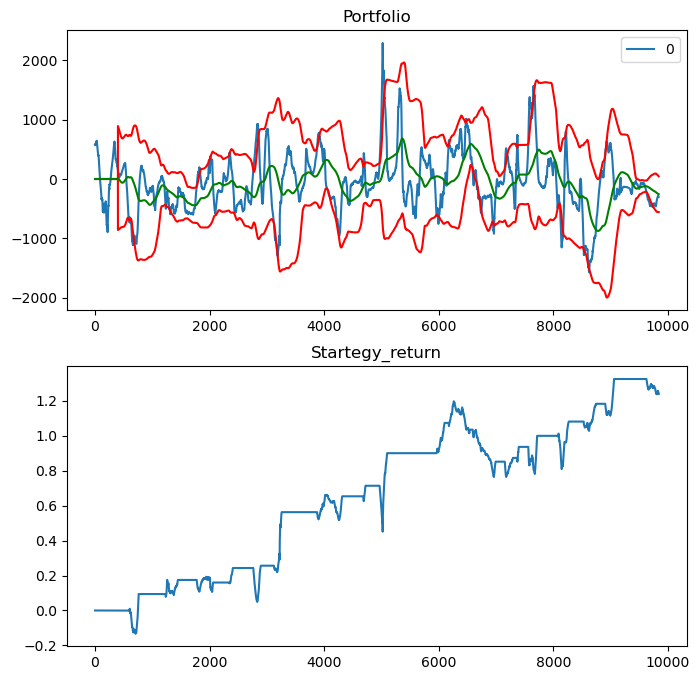

In [262]:
generate_backtest(demeaned_test, w, 400, factor = 2)  #with the training data    

In [225]:
#Appendix:
#Includes all Code snippets not necessary for the code


"""
This one takes average weightings. For range 1 till lag end, it will loop through i and can also skip stages (skipper)
It calculates the weightings across different time horizons and then 
"""

def optimized_weights(matrix:NDArray, lag_end: float, skipper:float, cutoff:float) -> NDArray:
    n = sort_matrix(matrix).shape[0]
    base = np.ones(n).reshape(-1, 1) 
    weighting = base * 0
    
    for i in range(1, lag_end//skipper):
        i *= skipper
        weighting += get_weights(matrix, i)

    weighting = weighting / (np.sum(weighting))
    return weighting